In [45]:

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [2]:
pip install transformers

     |████████████████████████████████| 778kB 8.7MB/s 
     |████████████████████████████████| 890kB 21.4MB/s 
     |████████████████████████████████| 3.0MB 45.0MB/s 
     |████████████████████████████████| 1.1MB 52.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b9577419e2be02124149a824b2438875d665be4bd274d48d30b77e02738e31e4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
from google.colab import files
uploaded = files.upload()

Saving ner1.csv to ner1.csv


In [12]:
import io
data = pd.read_csv(io.BytesIO(uploaded['ner1.csv']),encoding="latin1").fillna(method="ffill")
data.tail(10)

,Sentence #,Word,Tag
2337,Sentence: 111,and,o
2338,Sentence: 111,20-10-2019,deliveryToDate
2339,Sentence: 111,.,o
2340,Sentence: 112,buy,contractType
2341,Sentence: 112,oats,productId
2342,Sentence: 112,from,o
2343,Sentence: 112,Australia,originationCountryId
2344,Sentence: 112,to,o
2345,Sentence: 112,China,destinationCountryId
2346,Sentence: 112,.,o


In [13]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,  t) for w,  t in zip(s["Word"].values.tolist(),
                                                           
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [14]:
getter = SentenceGetter(data1)

In [15]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Buy',
 '200',
 'MT',
 'cotton',
 'of',
 'quality',
 'Cotton-A-Dry',
 'with',
 'tolerance',
 '2',
 '%',
 'buyer',
 'at',
 '120',
 'USD/MT',
 'flat',
 ',',
 'settled',
 'in',
 'AUD',
 '.']

In [17]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['contractType', 'itemQty', 'itemQtyUnitId', 'productId', 'o', 'o', 'quality', 'o', 'o', 'tolerance', 'toleranceType', 'toleranceLevel', 'o', 'priceDf', 'priceUnitId', 'priceTypeId', 'o', 'o', 'o', 'payInCurId', 'o']


In [18]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [19]:
tag2idx

{'0': 5,
 'PAD': 25,
 'applicableLawId': 1,
 'contractType': 24,
 'contract_type': 17,
 'cpProfileId': 9,
 'deliveryFromDate': 16,
 'deliveryToDate': 20,
 'destinationCountryId': 2,
 'incotermId': 4,
 'itemQty': 18,
 'itemQtyUnitId': 3,
 'o': 23,
 'originationCountryId': 8,
 'payInCurId': 7,
 'paymentTermId': 12,
 'priceDf': 11,
 'priceTypeId': 22,
 'priceUnitId': 19,
 'productId': 21,
 'quality': 10,
 'shipmentMode': 6,
 'tolerance': 0,
 'toleranceLevel': 13,
 'toleranceType': 15,
 'traderUserId': 14}

In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.5.1+cu101'

In [22]:
MAX_LEN = 75
bs = 32

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [24]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [26]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [27]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [28]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [29]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [30]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [31]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [32]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [33]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [34]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [35]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'3.0.2'

In [36]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [37]:
model.cuda();

In [40]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [47]:
from transformers import get_linear_schedule_with_warmup

epochs = 100
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [42]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=ae87be8dc5a4ceffde475471b4c9daa583e87905b5cd12cdf6cd2ed465aa0327
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [48]:
from seqeval.metrics import f1_score, accuracy_score

In [49]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   1%|          | 1/100 [00:00<01:31,  1.09it/s]

Average train loss: 1.4416364431381226
Validation loss: 1.0199726819992065
Validation Accuracy: 0.7335092348284961
Validation F1-Score: 0.4498480243161095



Epoch:   2%|▏         | 2/100 [00:01<01:29,  1.09it/s]

Average train loss: 1.0487823635339737
Validation loss: 0.7157431840896606
Validation Accuracy: 0.8284960422163589
Validation F1-Score: 0.6557377049180328



Epoch:   3%|▎         | 3/100 [00:02<01:28,  1.10it/s]

Average train loss: 0.6991930603981018
Validation loss: 0.49616971611976624
Validation Accuracy: 0.899736147757256
Validation F1-Score: 0.8295165394402035



Epoch:   4%|▍         | 4/100 [00:03<01:27,  1.10it/s]

Average train loss: 0.4430951476097107
Validation loss: 0.3545648157596588
Validation Accuracy: 0.9261213720316622
Validation F1-Score: 0.8762376237623763



Epoch:   5%|▌         | 5/100 [00:04<01:26,  1.10it/s]

Average train loss: 0.3967510722577572
Validation loss: 0.26171907782554626
Validation Accuracy: 0.9498680738786279
Validation F1-Score: 0.8987654320987655



Epoch:   6%|▌         | 6/100 [00:05<01:25,  1.10it/s]

Average train loss: 0.20503068901598454
Validation loss: 0.20409926772117615
Validation Accuracy: 0.9683377308707124
Validation F1-Score: 0.9303482587064676



Epoch:   7%|▋         | 7/100 [00:06<01:23,  1.11it/s]

Average train loss: 0.140533615835011
Validation loss: 0.1565762758255005
Validation Accuracy: 0.978891820580475
Validation F1-Score: 0.9478908188585609



Epoch:   8%|▊         | 8/100 [00:07<01:22,  1.11it/s]

Average train loss: 0.14830098301172256
Validation loss: 0.12514089047908783
Validation Accuracy: 0.9815303430079155
Validation F1-Score: 0.9504950495049505



Epoch:   9%|▉         | 9/100 [00:08<01:21,  1.11it/s]

Average train loss: 0.121969323605299
Validation loss: 0.09714375436306
Validation Accuracy: 0.9920844327176781
Validation F1-Score: 0.9754901960784313



Epoch:  10%|█         | 10/100 [00:09<01:20,  1.12it/s]

Average train loss: 0.06646073050796986
Validation loss: 0.07590899616479874
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  11%|█         | 11/100 [00:09<01:19,  1.12it/s]

Average train loss: 0.05145810008980334
Validation loss: 0.06751888990402222
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  12%|█▏        | 12/100 [00:10<01:18,  1.11it/s]

Average train loss: 0.04132723738439381
Validation loss: 0.06525139510631561
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  13%|█▎        | 13/100 [00:11<01:18,  1.11it/s]

Average train loss: 0.03876842185854912
Validation loss: 0.06074759364128113
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  14%|█▍        | 14/100 [00:12<01:17,  1.12it/s]

Average train loss: 0.04035585606470704
Validation loss: 0.05207909643650055
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  15%|█▌        | 15/100 [00:13<01:16,  1.12it/s]

Average train loss: 0.026522499043494463
Validation loss: 0.04401574283838272
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  16%|█▌        | 16/100 [00:14<01:15,  1.12it/s]

Average train loss: 0.023180621210485697
Validation loss: 0.04060305282473564
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  17%|█▋        | 17/100 [00:15<01:14,  1.12it/s]

Average train loss: 0.023790393490344286
Validation loss: 0.04079977795481682
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  18%|█▊        | 18/100 [00:16<01:13,  1.12it/s]

Average train loss: 0.03144537820480764
Validation loss: 0.042517609894275665
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  19%|█▉        | 19/100 [00:17<01:12,  1.12it/s]

Average train loss: 0.019868859089910984
Validation loss: 0.04109910875558853
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  20%|██        | 20/100 [00:17<01:11,  1.12it/s]

Average train loss: 0.014571523643098772
Validation loss: 0.04188157990574837
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  21%|██        | 21/100 [00:18<01:10,  1.12it/s]

Average train loss: 0.02782347286120057
Validation loss: 0.044168662279844284
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  22%|██▏       | 22/100 [00:19<01:09,  1.12it/s]

Average train loss: 0.014179953606799245
Validation loss: 0.04637772589921951
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  23%|██▎       | 23/100 [00:20<01:09,  1.11it/s]

Average train loss: 0.011210285243578255
Validation loss: 0.04585301876068115
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  24%|██▍       | 24/100 [00:21<01:08,  1.12it/s]

Average train loss: 0.011242753942497075
Validation loss: 0.044200003147125244
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  25%|██▌       | 25/100 [00:22<01:07,  1.12it/s]

Average train loss: 0.013008610461838543
Validation loss: 0.04395806044340134
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  26%|██▌       | 26/100 [00:23<01:06,  1.12it/s]

Average train loss: 0.009802544605918229
Validation loss: 0.04421946406364441
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  27%|██▋       | 27/100 [00:24<01:05,  1.11it/s]

Average train loss: 0.010949804680421948
Validation loss: 0.04585347697138786
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  28%|██▊       | 28/100 [00:25<01:04,  1.11it/s]

Average train loss: 0.008037170744501054
Validation loss: 0.048308245837688446
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  29%|██▉       | 29/100 [00:26<01:03,  1.12it/s]

Average train loss: 0.00765956164104864
Validation loss: 0.04964190721511841
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  30%|███       | 30/100 [00:26<01:02,  1.12it/s]

Average train loss: 0.007743814843706787
Validation loss: 0.050595689564943314
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  31%|███       | 31/100 [00:27<01:01,  1.12it/s]

Average train loss: 0.014065882307477295
Validation loss: 0.05037318915128708
Validation Accuracy: 0.9920844327176781
Validation F1-Score: 0.9829683698296837



Epoch:  32%|███▏      | 32/100 [00:28<01:00,  1.12it/s]

Average train loss: 0.00698745995759964
Validation loss: 0.049802154302597046
Validation Accuracy: 0.9920844327176781
Validation F1-Score: 0.9829683698296837



Epoch:  33%|███▎      | 33/100 [00:29<00:59,  1.12it/s]

Average train loss: 0.006758626666851342
Validation loss: 0.049806542694568634
Validation Accuracy: 0.9920844327176781
Validation F1-Score: 0.9829683698296837



Epoch:  34%|███▍      | 34/100 [00:30<00:58,  1.12it/s]

Average train loss: 0.006165419588796794
Validation loss: 0.049580167979002
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  35%|███▌      | 35/100 [00:31<00:58,  1.12it/s]

Average train loss: 0.005844828090630472
Validation loss: 0.04892204701900482
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  36%|███▌      | 36/100 [00:32<00:57,  1.12it/s]

Average train loss: 0.006177099305205047
Validation loss: 0.048469383269548416
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  37%|███▋      | 37/100 [00:33<00:56,  1.12it/s]

Average train loss: 0.005202946544159204
Validation loss: 0.04821735993027687
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  38%|███▊      | 38/100 [00:34<00:55,  1.12it/s]

Average train loss: 0.007149375800509006
Validation loss: 0.047903381288051605
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  39%|███▉      | 39/100 [00:34<00:54,  1.12it/s]

Average train loss: 0.006547469994984567
Validation loss: 0.04750726744532585
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  40%|████      | 40/100 [00:35<00:53,  1.12it/s]

Average train loss: 0.00468408758752048
Validation loss: 0.04809892550110817
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  41%|████      | 41/100 [00:36<00:52,  1.12it/s]

Average train loss: 0.004482918826397508
Validation loss: 0.04831827059388161
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  42%|████▏     | 42/100 [00:37<00:51,  1.12it/s]

Average train loss: 0.0046051424578763545
Validation loss: 0.04843727499246597
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  43%|████▎     | 43/100 [00:38<00:50,  1.12it/s]

Average train loss: 0.004661706101614982
Validation loss: 0.04868447408080101
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  44%|████▍     | 44/100 [00:39<00:50,  1.12it/s]

Average train loss: 0.00622884021140635
Validation loss: 0.04911189153790474
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  45%|████▌     | 45/100 [00:40<00:49,  1.12it/s]

Average train loss: 0.004247056203894317
Validation loss: 0.04949570819735527
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  46%|████▌     | 46/100 [00:41<00:48,  1.12it/s]

Average train loss: 0.004965073079802096
Validation loss: 0.04988734424114227
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  47%|████▋     | 47/100 [00:42<00:47,  1.12it/s]

Average train loss: 0.0042134911636821926
Validation loss: 0.05064397677779198
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  48%|████▊     | 48/100 [00:42<00:46,  1.12it/s]

Average train loss: 0.004055467317812145
Validation loss: 0.051307179033756256
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  49%|████▉     | 49/100 [00:43<00:45,  1.12it/s]

Average train loss: 0.0037952331476844847
Validation loss: 0.05171097815036774
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  50%|█████     | 50/100 [00:44<00:44,  1.12it/s]

Average train loss: 0.014897067158017308
Validation loss: 0.05151719972491264
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  51%|█████     | 51/100 [00:45<00:43,  1.12it/s]

Average train loss: 0.005112564307637513
Validation loss: 0.05100786313414574
Validation Accuracy: 0.9920844327176781
Validation F1-Score: 0.9829683698296837



Epoch:  52%|█████▏    | 52/100 [00:46<00:42,  1.12it/s]

Average train loss: 0.003582275821827352
Validation loss: 0.05034764111042023
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  53%|█████▎    | 53/100 [00:47<00:41,  1.12it/s]

Average train loss: 0.0035750275710597634
Validation loss: 0.04967688024044037
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  54%|█████▍    | 54/100 [00:48<00:40,  1.12it/s]

Average train loss: 0.003931668819859624
Validation loss: 0.04918855428695679
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  55%|█████▌    | 55/100 [00:49<00:40,  1.12it/s]

Average train loss: 0.00322475383291021
Validation loss: 0.04888108745217323
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  56%|█████▌    | 56/100 [00:50<00:39,  1.12it/s]

Average train loss: 0.0034786456380970776
Validation loss: 0.04880424216389656
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  57%|█████▋    | 57/100 [00:51<00:38,  1.12it/s]

Average train loss: 0.004530634498223662
Validation loss: 0.04868219047784805
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  58%|█████▊    | 58/100 [00:51<00:37,  1.12it/s]

Average train loss: 0.0035447024856694043
Validation loss: 0.04844331368803978
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  59%|█████▉    | 59/100 [00:52<00:37,  1.10it/s]

Average train loss: 0.003123668546322733
Validation loss: 0.04833027720451355
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  60%|██████    | 60/100 [00:53<00:36,  1.10it/s]

Average train loss: 0.0031710859038867056
Validation loss: 0.04817327484488487
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  61%|██████    | 61/100 [00:54<00:35,  1.10it/s]

Average train loss: 0.003227041510399431
Validation loss: 0.048137981444597244
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  62%|██████▏   | 62/100 [00:55<00:34,  1.10it/s]

Average train loss: 0.0029016816115472466
Validation loss: 0.04819442331790924
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  63%|██████▎   | 63/100 [00:56<00:33,  1.10it/s]

Average train loss: 0.003011877997778356
Validation loss: 0.04828149452805519
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  64%|██████▍   | 64/100 [00:57<00:32,  1.11it/s]

Average train loss: 0.003209848830010742
Validation loss: 0.048347506672143936
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  65%|██████▌   | 65/100 [00:58<00:31,  1.11it/s]

Average train loss: 0.00575871579349041
Validation loss: 0.04840472340583801
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  66%|██████▌   | 66/100 [00:59<00:30,  1.11it/s]

Average train loss: 0.0029860768700018525
Validation loss: 0.048622000962495804
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  67%|██████▋   | 67/100 [01:00<00:29,  1.11it/s]

Average train loss: 0.0028977261972613633
Validation loss: 0.04878704994916916
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  68%|██████▊   | 68/100 [01:00<00:28,  1.11it/s]

Average train loss: 0.004400093574076891
Validation loss: 0.04888418689370155
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  69%|██████▉   | 69/100 [01:01<00:27,  1.12it/s]

Average train loss: 0.002873850811738521
Validation loss: 0.04912802204489708
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  70%|███████   | 70/100 [01:02<00:26,  1.12it/s]

Average train loss: 0.002870402007829398
Validation loss: 0.04938472434878349
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  71%|███████   | 71/100 [01:03<00:25,  1.12it/s]

Average train loss: 0.0025729745102580637
Validation loss: 0.04964679107069969
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  72%|███████▏  | 72/100 [01:04<00:25,  1.12it/s]

Average train loss: 0.0035404088557697833
Validation loss: 0.04968421161174774
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  73%|███████▎  | 73/100 [01:05<00:24,  1.12it/s]

Average train loss: 0.0028570236754603684
Validation loss: 0.04975971207022667
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  74%|███████▍  | 74/100 [01:06<00:23,  1.12it/s]

Average train loss: 0.0025930533302016556
Validation loss: 0.0498313345015049
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  75%|███████▌  | 75/100 [01:07<00:22,  1.12it/s]

Average train loss: 0.0028481121407821774
Validation loss: 0.04999320209026337
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  76%|███████▌  | 76/100 [01:08<00:21,  1.12it/s]

Average train loss: 0.0030532225500792265
Validation loss: 0.050026629120111465
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  77%|███████▋  | 77/100 [01:08<00:20,  1.12it/s]

Average train loss: 0.002380297693889588
Validation loss: 0.049963101744651794
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  78%|███████▊  | 78/100 [01:09<00:19,  1.12it/s]

Average train loss: 0.0024045755271799862
Validation loss: 0.04992038756608963
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  79%|███████▉  | 79/100 [01:10<00:18,  1.12it/s]

Average train loss: 0.0029101254767738283
Validation loss: 0.04988468438386917
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  80%|████████  | 80/100 [01:11<00:17,  1.12it/s]

Average train loss: 0.0028753258229698986
Validation loss: 0.049869246780872345
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  81%|████████  | 81/100 [01:12<00:17,  1.11it/s]

Average train loss: 0.00249734113458544
Validation loss: 0.04983723908662796
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  82%|████████▏ | 82/100 [01:13<00:16,  1.11it/s]

Average train loss: 0.0025036598090082407
Validation loss: 0.04973156377673149
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  83%|████████▎ | 83/100 [01:14<00:15,  1.11it/s]

Average train loss: 0.002513028448447585
Validation loss: 0.049680426716804504
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  84%|████████▍ | 84/100 [01:15<00:14,  1.11it/s]

Average train loss: 0.0023002933303359896
Validation loss: 0.04967581853270531
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  85%|████████▌ | 85/100 [01:16<00:13,  1.12it/s]

Average train loss: 0.0033819462987594306
Validation loss: 0.0497174970805645
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  86%|████████▌ | 86/100 [01:17<00:12,  1.12it/s]

Average train loss: 0.002700692799407989
Validation loss: 0.04979368671774864
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  87%|████████▋ | 87/100 [01:17<00:11,  1.12it/s]

Average train loss: 0.002315940451808274
Validation loss: 0.04985777661204338
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  88%|████████▊ | 88/100 [01:18<00:10,  1.12it/s]

Average train loss: 0.002318959857802838
Validation loss: 0.04992523416876793
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  89%|████████▉ | 89/100 [01:19<00:09,  1.12it/s]

Average train loss: 0.0025465478538535535
Validation loss: 0.049990419298410416
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  90%|█████████ | 90/100 [01:20<00:08,  1.12it/s]

Average train loss: 0.003669632162200287
Validation loss: 0.05007898807525635
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  91%|█████████ | 91/100 [01:21<00:08,  1.12it/s]

Average train loss: 0.0024880770361050963
Validation loss: 0.050226859748363495
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  92%|█████████▏| 92/100 [01:22<00:07,  1.12it/s]

Average train loss: 0.00242212088778615
Validation loss: 0.05031242594122887
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  93%|█████████▎| 93/100 [01:23<00:06,  1.12it/s]

Average train loss: 0.002382212463999167
Validation loss: 0.050357233732938766
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  94%|█████████▍| 94/100 [01:24<00:05,  1.12it/s]

Average train loss: 0.0022601968667004257
Validation loss: 0.05037236958742142
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  95%|█████████▌| 95/100 [01:25<00:04,  1.12it/s]

Average train loss: 0.0028671364998444915
Validation loss: 0.05038361996412277
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  96%|█████████▌| 96/100 [01:25<00:03,  1.12it/s]

Average train loss: 0.0022269167529884726
Validation loss: 0.050407443195581436
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  97%|█████████▋| 97/100 [01:26<00:02,  1.12it/s]

Average train loss: 0.0030421180417761207
Validation loss: 0.050420455634593964
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  98%|█████████▊| 98/100 [01:27<00:01,  1.12it/s]

Average train loss: 0.0034532987629063427
Validation loss: 0.05050509050488472
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch:  99%|█████████▉| 99/100 [01:28<00:00,  1.12it/s]

Average train loss: 0.0022201556421350688
Validation loss: 0.05058155208826065
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



Epoch: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]

Average train loss: 0.002633446827530861
Validation loss: 0.05060179904103279
Validation Accuracy: 0.9947229551451188
Validation F1-Score: 0.9853658536585367



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


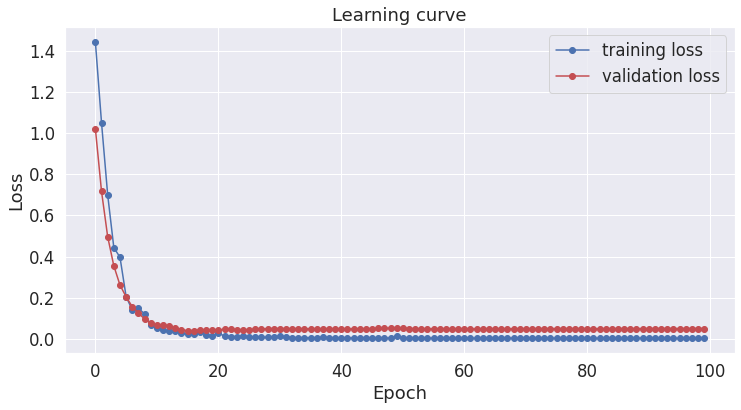

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [71]:
test_sentence = """
sell 20 MT for a flat price at 2 % tolerance.
"""

In [72]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [73]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [74]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [75]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

contractType	[CLS]
contractType	sell
itemQty	20
itemQtyUnitId	MT
o	for
o	a
priceTypeId	flat
o	price
o	at
tolerance	2
toleranceType	%
o	tolerance
o	.
contractType	[SEP]
